# Select the ambiguous set

In [1]:
import json
import random
random.seed(1)
import sys
sys.path.append('../')
from dy_filtering import read_training_dynamics, compute_train_dy_metrics

TASK_NAME = 'mnli'
MODEL = 'roberta-large'
BURN_OUT = 5

# 读取并合并到一个文件
td = read_training_dynamics(f'../dy_log/{TASK_NAME}/{MODEL}/')
# 计算 metrics，转化成一个 dataframe
td_df, _ = compute_train_dy_metrics(td, burn_out=BURN_OUT)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-08-29 00:15:55,643 - INFO - selection_utils - Reading 5 files from ../dy_log/mnli/roberta-large/training_dynamics ...
100%|██████████| 5/5 [00:13<00:00,  2.70s/it]
2022-08-29 00:16:09,169 - INFO - selection_utils - Read training dynamics for 392702 train instances.
2022-08-29 00:16:09,185 - INFO - dy_filtering - Computing training dynamics across 5 epochs
2022-08-29 00:16:09,186 - INFO - dy_filtering - Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness
100%|██████████| 392702/392702 [01:02<00:00, 6308.33it/s]


In [68]:
td[230221]

{'gold': 2,
 'logits': [[-0.7431744933128357, -1.645121693611145, 2.125744104385376],
  [-0.9769892692565918, -1.4837790727615356, 1.9871121644973755],
  [-0.8238453269004822, -1.079584002494812, 1.640381097793579],
  [0.264363169670105, -1.9889315366744995, 1.6330556869506836],
  [-0.8030975461006165, -2.125100612640381, 2.8006227016448975]]}

In [31]:
PROPORTION = 0.33
# 直接按照metric排序去挑样本（可能导致类别不平衡）
sorted_df = td_df.sort_values(by='confidence', ascending=False)
selected_df = sorted_df.head(n=int(PROPORTION * len(sorted_df)))

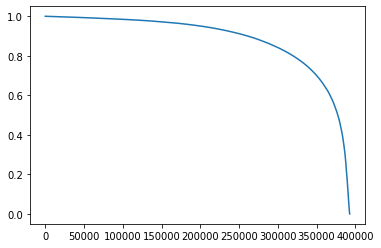

In [25]:
# 观察一下分布
import matplotlib.pyplot as plt
values = list(sorted_df['confidence'])
plt.plot(values)

In [29]:
indices = list(sorted_df[sorted_df['confidence']>0.6][sorted_df['confidence']<0.8]['guid'])
len(indices)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


47932

In [34]:
# 去掉前面10%
indices = list(selected_df['guid'])
print(len(indices))
indices = indices[int(0.1 * len(indices)):]
print(len(indices))

129591
116632


In [35]:
# 保存
with open(f'../dy_log/{TASK_NAME}/{MODEL}/selected_indices_conf_top0.33-10%.txt', 'w') as f:
    for idx in indices:
        f.write(str(idx) + '\n')

In [20]:
# 读取
with open(f'../dy_log/{TASK_NAME}/{MODEL}/selected_indices.txt', 'r') as f:
    indices = [int(x) for x in f.readlines()]

# 样本观察

In [2]:
from datasets import load_dataset
dataset = load_dataset('glue','mnli')
train_set = dataset['train']
print(train_set)
orig_ids = train_set['idx']
labels = train_set['label']
len(orig_ids), max(orig_ids)

2022-08-29 00:23:00,838 - WARNING - datasets.builder - Reusing dataset glue (/home/yegong/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 5/5 [00:00<00:00, 923.69it/s]


Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 392702
})


(392702, 392701)

In [3]:
metric = 'confidence'
sorted_df = td_df.sort_values(by=metric, ascending=False)
ids = list(sorted_df['guid'])
values = list(sorted_df[metric])

In [4]:
# 查看某个具体样本
for i in range(10):
    print(train_set[orig_ids.index(ids[i])],'\n')

{'premise': "Slate is scheduled to take up residence Monday, Oct. 27, as an anchor tenant on AOL's news-channel newsstand.", 'hypothesis': "AOL turned down Slate and won't offer them a spot on the newsstand.", 'label': 2, 'idx': 117829} 

{'premise': 'The Congress has underscored the consequences of human capital weaknesses through a wide range of oversight hearings held over the last few years.', 'hypothesis': 'There have never been any hearings on human capital weaknesses.', 'label': 2, 'idx': 73137} 

{'premise': 'The F/A-18 E/F fighter and the AIM-9X missile were based extensively on predecessor programs and employed similar tools to capture design and manufacturing knowledge at critical program junctures.', 'hypothesis': 'The fighters and missile were not based on anything.', 'label': 2, 'idx': 375296} 

{'premise': 'uh we have a friend who works who is a secretary for TCU you know up here they give you scholarship a hundred percent', 'hypothesis': "We don't know a single person w

In [5]:
from tqdm import tqdm
# 按照 metric 排序的labels
sorted_labels = []
for i in tqdm(ids):
    sorted_labels.append(labels[i])
    # sorted_labels.append(labels[orig_ids.index(i)])

100%|██████████| 392702/392702 [00:00<00:00, 3132432.98it/s]


In [9]:
# 看看如果直接按照metric排序去取数据，各类别的数量情况：
import matplotlib.pyplot as plt
from collections import Counter
top = int(len(sorted_labels) * 0.01)
# top=1000
d = Counter(sorted_labels[:top])
d, values[top]

(Counter({2: 3927}), 0.9993276238441468)

2022-08-29 00:23:48,965 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-08-29 00:23:48,966 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-08-29 00:23:48,968 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-08-29 00:23:48,969 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


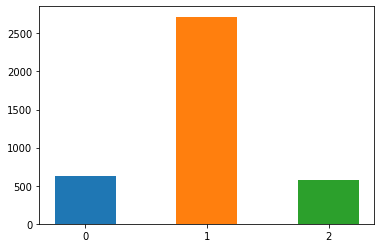

In [8]:
import matplotlib.pyplot as plt
for x in [0,1,2]:
    if x not in d:
        d[x] = 0
for x in sorted(list(d.keys())):
    plt.bar(str(x), d[x], 0.5, label=str(x))

In [10]:
ids_for_certain_label0 = [i for i in range(len(sorted_labels)) if sorted_labels[i] == 0]
ids_for_certain_label1 = [i for i in range(len(sorted_labels)) if sorted_labels[i] == 1]
ids_for_certain_label2 = [i for i in range(len(sorted_labels)) if sorted_labels[i] == 2]

len(ids_for_certain_label0),len(ids_for_certain_label1),len(ids_for_certain_label2)

(130899, 130900, 130903)

In [42]:
# 查看某个类别最easy/hard的样本
for i in range(20):
    print(train_set[orig_ids.index(ids[ids_for_certain_label2[-i]])],'\n') # 其实可以去掉 orig_ids.index

{'premise': "Slate is scheduled to take up residence Monday, Oct. 27, as an anchor tenant on AOL's news-channel newsstand.", 'hypothesis': "AOL turned down Slate and won't offer them a spot on the newsstand.", 'label': 2, 'idx': 117829} 

{'premise': "I'll advertise in the personal column of the Times, beginning 'Shipmate.'  ", 'hypothesis': 'The Times will get a lot of traffic to our advertisement.', 'label': 2, 'idx': 276411} 

{'premise': 'The Kal is awful, said one man, pointing at the man with the iron jaw.', 'hypothesis': 'The man pointed at Kal and mentioned how awful he is.', 'label': 2, 'idx': 247288} 

{'premise': 'In the other factor, the federal CIO tends to be constrained by organizational attributes typical of the federal sector.', 'hypothesis': 'The federal CIO tends to be constrained by organizational attributes', 'label': 2, 'idx': 156010} 

{'premise': 'Major statutes now in their first years of implementation hold substantial promise for creating a more accountable a

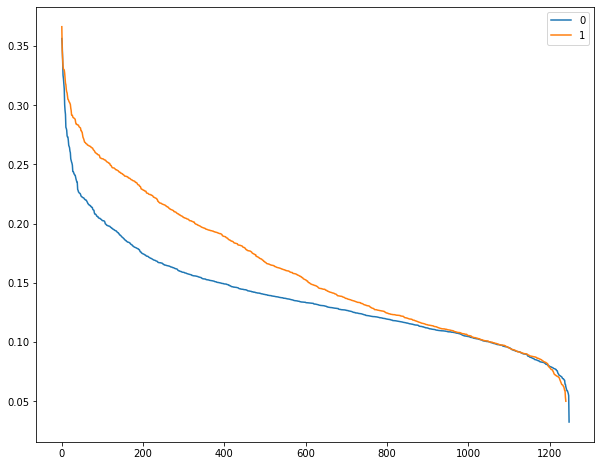

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
plt.plot([values[i] for i in ids_for_certain_label0], label='0')
plt.plot([values[i] for i in ids_for_certain_label1], label='1')
# plt.plot([values[i] for i in ids_for_certain_label2], label='2')
plt.legend()

In [20]:
# 构造一个类别平衡的集合
n = int(len(sorted_labels) * 0.165)
indices = ids_for_certain_label0[0:0+n] + ids_for_certain_label1[0:0+n] #+ ids_for_certain_label2[0:0+n]
print(len(indices))

# 保存
with open(f'../dy_log/{TASK_NAME}/{MODEL}/selected_indices_ambi_top0.33_balance.txt', 'w') as f:
    for idx in indices:
        f.write(str(idx) + '\n')

820


# weak vs. strong 模型的样本难度迁移

In [26]:
from dy_filtering import read_training_dynamics, compute_train_dy_metrics

In [41]:
td_weak = read_training_dynamics('../dy_log/mnli/distilbert-base-cased/')
td_strong = read_training_dynamics('../dy_log/mnli/roberta-large/')

td_df_weak, _ = compute_train_dy_metrics(td_weak, burn_out=5)
td_df_strong, _ = compute_train_dy_metrics(td_strong, burn_out=5)

2022-08-29 06:13:16,780 - INFO - selection_utils - Reading 5 files from ../dy_log/mnli/distilbert-base-cased/training_dynamics ...
100%|██████████| 5/5 [00:13<00:00,  2.80s/it]
2022-08-29 06:13:30,766 - INFO - selection_utils - Read training dynamics for 392702 train instances.
2022-08-29 06:13:31,034 - INFO - selection_utils - Reading 5 files from ../dy_log/mnli/roberta-large/training_dynamics ...
100%|██████████| 5/5 [00:14<00:00,  2.93s/it]
2022-08-29 06:13:45,671 - INFO - selection_utils - Read training dynamics for 392702 train instances.
2022-08-29 06:13:45,756 - INFO - dy_filtering - Computing training dynamics across 5 epochs
2022-08-29 06:13:45,757 - INFO - dy_filtering - Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness
100%|██████████| 392702/392702 [01:01<00:00, 6363.12it/s]
2022-08-29 06:14:49,459 - INFO - dy_filtering - Computing training dynamics across 5 epochs
2022-08-29 06:14:49,459 - INFO - dy_filtering - Metrics computed: con

In [170]:
metric = 'confidence'
sorted_df = td_df_strong.sort_values(by=metric, ascending=False)
ids = list(sorted_df['guid'])
values = list(sorted_df[metric])

from tqdm import tqdm
# 按照 metric 排序的labels
sorted_labels = []
for i in tqdm(ids):
    sorted_labels.append(labels[i])
    # sorted_labels.append(labels[orig_ids.index(i)])

ids_for_certain_label0 = [i for i in range(len(sorted_labels)) if sorted_labels[i] == 0]
ids_for_certain_label1 = [i for i in range(len(sorted_labels)) if sorted_labels[i] == 1]
ids_for_certain_label2 = [i for i in range(len(sorted_labels)) if sorted_labels[i] == 2]

100%|██████████| 392702/392702 [00:00<00:00, 3079000.97it/s]


In [171]:
N = 5000
top_ids_label0 = [ids[id] for id in [id for id in ids_for_certain_label0[:N]]]
top_ids_label1 = [ids[id] for id in [id for id in ids_for_certain_label1[:N]]]
top_ids_label2 = [ids[id] for id in [id for id in ids_for_certain_label2[:N]]]

Plotting figure for mnli using the weak model ...


Text(0, 0.5, 'confidence')

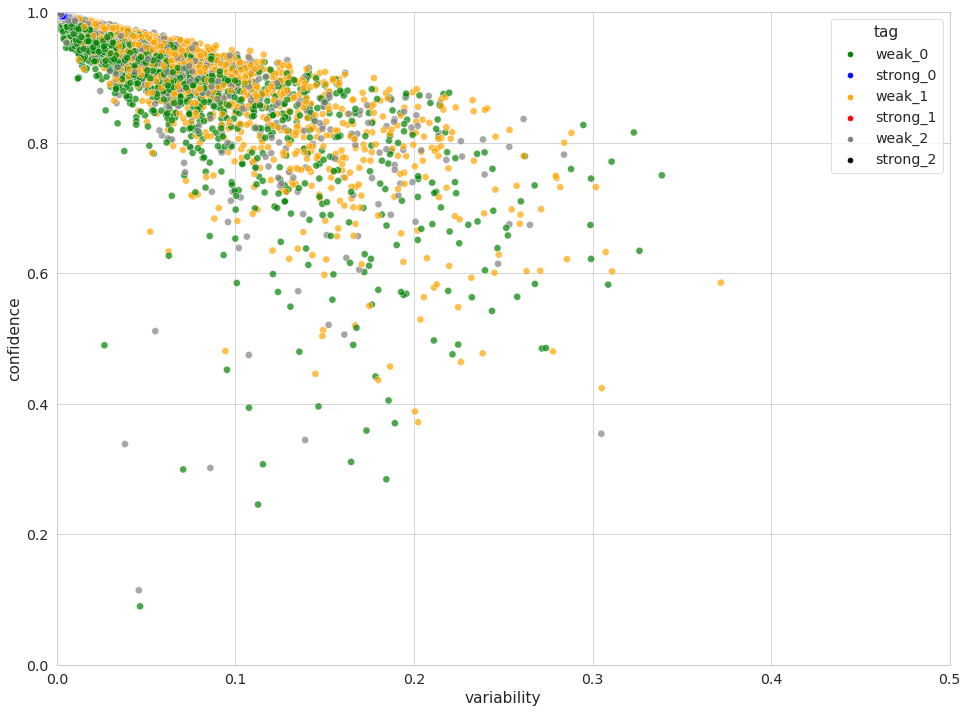

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Set style.
sns.set(style='whitegrid', font_scale=1.6, context='paper') # font='Georgia'
print(f"Plotting figure for {title} using the {model} model ...")
fig, ax0 = plt.subplots(1, 1, figsize=(16, 12))

# --------------------------------

def get_selected_df(selected_ids,label):
    selected_weak_df = td_df_weak[td_df_weak['guid'].isin(selected_ids)].copy() # .copy()是为了防止SettingWithCopyWarning Warning
    selected_weak_df.loc[:,'model'] = 'weak'
    selected_strong_df = td_df_strong[td_df_strong['guid'].isin(selected_ids)].copy()
    selected_strong_df.loc[:, 'model'] = 'strong'
    selected_df = pd.concat([selected_weak_df,selected_strong_df])
    selected_df['label'] = label
    return selected_df

def get_selected_df_(selected_ids,label):
    selected_weak_df = td_df_weak[td_df_weak['guid'].isin(selected_ids)].copy() # .copy()是为了防止SettingWithCopyWarning Warning
    selected_weak_df.loc[:,'tag'] = 'weak_%s'%label
    selected_strong_df = td_df_strong[td_df_strong['guid'].isin(selected_ids)].copy()
    selected_strong_df.loc[:, 'tag'] = 'strong_%s'%label
    selected_df = pd.concat([selected_weak_df,selected_strong_df])
    return selected_df

selected_df0 = get_selected_df_(top_ids_label0,'0')
selected_df1 = get_selected_df_(top_ids_label1,'1')
selected_df2 = get_selected_df_(top_ids_label2,'2')

dataframe = pd.concat([selected_df0,selected_df1,selected_df2])
plot_dir = ''
hue_metric = 'tag'
title = 'mnli'
model = 'weak'
show_hist = True
max_instances_to_plot = 55000 #55000
plot.set_title(f"{title}-{model} Data Map", fontsize=17)
# --------------------------------


main_metric = 'variability'
other_metric = 'confidence'

# Subsample data to plot, so the plot is not too busy.
dataframe = dataframe.sample(n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe))

# Normalize correctness to a value between 0 and 1.
dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
dataframe['correct.'] = [float(f"{x:.1f}") for x in dataframe['corr_frac']]

hue = hue_metric
num_hues = len(dataframe[hue].unique().tolist())
style = hue_metric if num_hues < 8 else None

hue_order = ['weak_0','strong_0','weak_1','strong_1','weak_2','strong_2']

# Make the scatterplot.
# Choose a palette.
pal = {
    'weak_0': 'green',
    'strong_0': 'blue',
    'weak_1': 'orange',
    'strong_1': 'red',
    'weak_2': 'gray',
    'strong_2': 'black',
}


plot = sns.scatterplot(x=main_metric, y=other_metric,
                       ax=ax0, data=dataframe, hue=hue,
                       palette=pal, s=50, hue_order=hue_order, alpha=0.7) # style=style 添加style的话，就会使用不用的 marker，但是就没法保证 legend 按照值的大小排列了


plot.set(ylim=(0, 1))
plot.set(xlim=(0, 0.5))

plot.set_xlabel('variability')
plot.set_ylabel('confidence')



In [135]:
df1 = dataframe[dataframe['tag'] == 'strong_2']
d1 = {k:v for k,v in zip(list(df1['guid']),list(df1['confidence']))}
df2 = dataframe[dataframe['tag'] == 'weak_2']
d2 = {k:v for k,v in zip(list(df2['guid']),list(df2['confidence']))}

diff_d = {k:d2[k]-d1[k] for k in d1}

In [145]:
len([x for x in ids_sorted_by_diff if x[1] > 0.5])

68

In [141]:
# 按照从strong到weak的confidence变化量来排序（即使用弱模型反而学的更好）
ids_sorted_by_diff = sorted(diff_d.items(), key=lambda x:x[1], reverse=True)
"""
ids_sorted_by_diff:
[(362067, 0.9685692203696817),
 (208185, 0.8036513447179459),
 (351828, 0.8023576776846312),
 (225441, 0.7791670577600598),
 (28851, 0.7505485706031323),
 (390127, 0.7216253193910234),
 ...]
 """

# 查看样本
for i in range(60):
    print(train_set[ids_sorted_by_diff[i][0]],'\n') # 其实可以去掉 orig_ids.index

{'premise': 'On the east wall are two images showing Byzantine emperors and emperesses making offerings to Christ on his throne (to the left), and to the Virgin and Child.', 'hypothesis': 'There are no images on the west wall at all.  ', 'label': 2, 'idx': 362067} 

{'premise': "Following a disastrous offensive by government troops on the rebels' mountain strongholds in 1958, on 1 January 1959 Batista fled the country for the Dominican Republic.", 'hypothesis': 'Batista fled to Dominica in 1959.', 'label': 2, 'idx': 208185} 

{'premise': 'right just have to take care of them and water them uh so they get established put some uh uh some uh uh', 'hypothesis': 'If you do not water them they will not get established.  ', 'label': 2, 'idx': 351828} 

{'premise': 'The Royal architects Edwin Lutyens and Herbert Baker created a monumental New Delhi with triumphal arches, palaces, gigantic government buildings, and sweeping avenues radiating from circles (for easy riot control) the stuff of an 

In [ ]:
weak_ids_sorted = sorted(d2.items(), key=lambda x:x[1], reverse=True)

# 查看样本
for i in range(20):
    print(train_set[weak_ids_sorted[i][0]],'\n') # 其实可以去掉 orig_ids.index

# 针对 NLI 数据集的 Free Lunch —— 通过 reverse sentence pair 来增强

In [190]:
td = read_training_dynamics('../dy_log/mnli/roberta-large/')

td_df, _ = compute_train_dy_metrics(td, burn_out=5)

metric = 'confidence'
sorted_df = td_df.sort_values(by=metric, ascending=True)
ids = list(sorted_df['guid'])
values = list(sorted_df[metric])

from tqdm import tqdm
# 按照 metric 排序的labels
sorted_labels = []
for i in tqdm(ids):
    sorted_labels.append(labels[i])
    # sorted_labels.append(labels[orig_ids.index(i)])

ids_for_certain_label0 = [i for i in range(len(sorted_labels)) if sorted_labels[i] == 0]
ids_for_certain_label1 = [i for i in range(len(sorted_labels)) if sorted_labels[i] == 1]
ids_for_certain_label2 = [i for i in range(len(sorted_labels)) if sorted_labels[i] == 2]


N = 10000
top_ids_label0 = [ids[id] for id in [id for id in ids_for_certain_label0[:N]]]
top_ids_label1 = [ids[id] for id in [id for id in ids_for_certain_label1[:N]]]
top_ids_label2 = [ids[id] for id in [id for id in ids_for_certain_label2[:N]]]

100%|██████████| 392702/392702 [00:00<00:00, 3052354.56it/s]


In [194]:
with open('mnli_hard_label2_top10k.txt','w') as f:
    f.writelines([str(x)+'\n' for x in top_ids_label2])

with open('mnli_hard_label2_top10k.txt','r') as f:
    ii = [int(x) for x in f.readlines()]
len(ii)

10000

In [151]:
# 对于label=2的样本，可以直接翻转一下，label依然为2：
orig_premise_list = data['premise']
orig_hypothesis_list = data['hypothesis']
new_data = data.remove_columns(['hypothesis','premise']).add_column('premise', orig_hypothesis_list).add_column('hypothesis', orig_premise_list)
new_data

Dataset({
    features: ['label', 'idx', 'premise', 'hypothesis'],
    num_rows: 100
})

In [169]:
# 可能用到的map函数
def get_reverse(example):
    if example['label'] == 2:
        premise, hypothesis = example['premise'], example['hypothesis']
        new_example = example.copy()
        new_example['hypothesis'], new_example['premise'] = premise, hypothesis
        return new_example
    else:
        return example

data[8], get_reverse(data[8])

({'premise': 'Gays and lesbians.',
  'hypothesis': 'Heterosexuals.',
  'label': 2,
  'idx': 8},
 {'premise': 'Heterosexuals.',
  'hypothesis': 'Gays and lesbians.',
  'label': 2,
  'idx': 8})

In [1]:
# 对于label=0/1的样本，需要使用模型来预测，无论如何，类别不应该是2，所以只需要在0/1中挑


# ambiguous first 权重分配

In [5]:
import sys
sys.path.append('../')
from dy_filtering import read_training_dynamics, compute_train_dy_metrics

td = read_training_dynamics('../dy_log/mnli/roberta-large/')

td_df, _ = compute_train_dy_metrics(td, burn_out=5)

metric = 'confidence'
sorted_df = td_df.sort_values(by=metric, ascending=True)
ids = list(sorted_df['guid'])
values = list(sorted_df[metric])

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-02 02:23:11,500 - INFO - selection_utils - Reading 5 files from ../dy_log/mnli/roberta-large/training_dynamics ...
100%|██████████| 5/5 [00:13<00:00,  2.71s/it]
2022-09-02 02:23:25,071 - INFO - selection_utils - Read training dynamics for 392702 train instances.
2022-09-02 02:23:25,087 - INFO - dy_filtering - Computing training dynamics across 5 epochs
2022-09-02 02:23:25,087 - INFO - dy_filtering - Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness
100%|██████████| 392702/392702 [01:02<00:00, 6259.66it/s]


In [6]:

def ambi_first_weight(prob, alpha, k=2):
    """
    prob: 样本的预测概率
    alpha: 函数的中心点，ambiguous的锚点
    k: 一个系数，越大则函数越陡峭(目前仅支持k=2,4,6,8,... 偶数次方)
    """
    weight = 1 - (prob - alpha) ** k / (alpha ** k)
    return weight

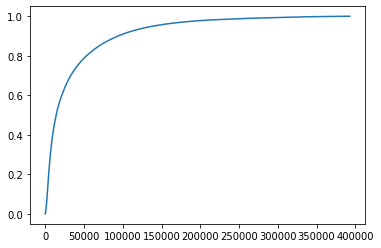

In [8]:
import matplotlib.pyplot as plt
plt.plot(values)

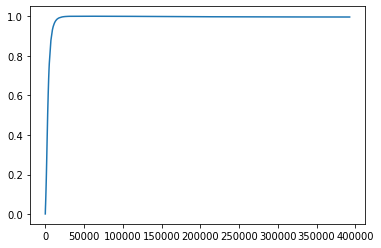

In [48]:
weighted_values = [ambi_first_weight(v,0.8,k=4) for v in values]
plt.plot(weighted_values)

In [49]:
import pickle
idx2weight = {i:w for i,w in zip(ids, weighted_values)}
# 保存
with open('mnli-roberta-weight-a0.8-k4.weight', 'wb') as handle:
    pickle.dump(idx2weight, handle)

# # 读取
# with open('mnli-roberta-weight-1.weight', 'rb') as handle:
#     check = pickle.load(handle)
# check == idx2weight

In [34]:
from torch.nn import CrossEntropyLoss
import torch
loss_fct = CrossEntropyLoss(reduction="none")
logits = torch.Tensor([[0.8,0.1,1.3],[1.1,2.2,0.9]])
labels = torch.Tensor([0,2]).to(dtype=torch.long)

In [42]:
losses = loss_fct(logits,labels)
losses,losses.mean()

(tensor([1.1459, 1.7734]), tensor(1.4596))

In [37]:
weights = torch.Tensor([0.1,0.9])
weights

tensor([0.1000, 0.9000])

In [41]:
(losses * weights).mean()

tensor(0.8553)